(counts_prediction_notebook)=
# La predizione delle frequenze 

Nella ricerca sul trauma, come in altri campi di ricerca, il risultato di interesse può essere rappresentato dalla frequenza del numero di episodi che si verificano in un dato periodo di tempo. Nel caso della ricerca sulla violenza domestica, ad esempio, potremmo esaminare il tasso di atti aggressivi durante l'intervallo tra un momento temporale di baseline e un'intervista di follow-up. Altri esempi di risultati esprimibili in termini di frequenze nalla ricerca post-traumatica includono la frequenza dell'abuso di sostanze durante un periodo di osservazione o il numero di interventi della polizia durante un dato periodo.

In questo capitolo esamineremo l'uso della predizione bayesiana per predire il numero di aggressioni nei confronti del partner nelle relazioni di coppia. I dati presentati sono tratti da uno studio che esamina la frequenza di episodi di aggressione messi in atto da pazienti di sesso maschile che avevano recentemente iniziato un programma di trattamento dell'alcol nei confronti del loro partner di sesso femminile.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import statistics
import arviz as az
import seaborn as sns
import scipy.stats as st 
import pymc as pm
import xarray as xr
from scipy.constants import golden
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={'figure.figsize': (5.0, 5.0/golden)},
)
SEED = 42
rng = np.random.default_rng(SEED)

La frequenza degli episodi di violenza, così come altri fenomeni quantificabili in termini di frequenze assolute, può essere modellata da un processo di Poisson, che si basa sul presupposto che gli eventi siano casuali e abbiano la stessa probabilità di verificarsi in qualsiasi momento. Naturalmente, questa ipotesi non è sempre valida, ma spesso è sufficiente per la modellazione.

## La distribuzione a priori

In una ricerca sui pazienti che avevano recentemente iniziato un programma di trattamento per l'abuso o la dipendenza da alcol, {cite:t}`gagnon2008poisson` hanno trovato che, in un periodo di 6 mesi, il numero di assalti fisici da parte dei pazienti di genere maschile nei confronti dei loro partner femminili è uguale, in media, a 11.46 ($SD$ = 25.79; $n$ = 114). Per questi dati, la distribuzione del numero di episodi di aggressione fisica può, approssimativamente, essere rappresentata dalla seguente distribuzione esponenziale. Considereremo questa la  distribuzione a priori relativa alle nostre credenze circa la frequenza media $\mu$ degli episodi di aggressione nei confronti del partner per questa popolazione, in un periodo di 6 mesi.

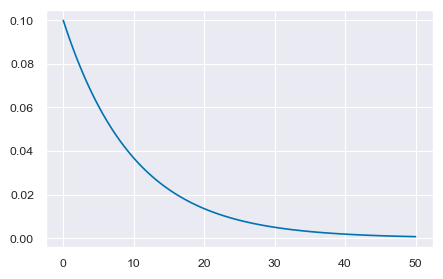

In [3]:
x = np.linspace (0, 50, 100) 
y = st.expon.pdf(x, 0, 10)
plt.plot(x, y)

In [4]:
r = st.expon.rvs(0, 10, size=100000)
r.mean()

10.007886017243596

Rappresentiamo ora la nostra credenza a priori utilizzando in un modello bayesiano utilizzando PyMC.

Consideriamo un singlo individuo di genere maschile appartenente a questa popolazione. Se, in media, in 6 mesi ci aspettiamo un numero di episodi di violenza pari a 11.46, possiamo descrivere il numero di episodi di violenza per un singolo individuo con la seguente distribuzione di Poisson.

In [5]:
l = 1/10

with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    idata = pm.sample_prior_predictive(samples=2000, random_seed=rng)

Sampling: [mu]


Vediamo qui 2000 campioni casuali estratti dalla distribuzione a priori. Il risultato è simile alla distribuzione di densità teorica rappresentata nel grafico precedente.

<AxesSubplot: title={'center': 'mu'}>

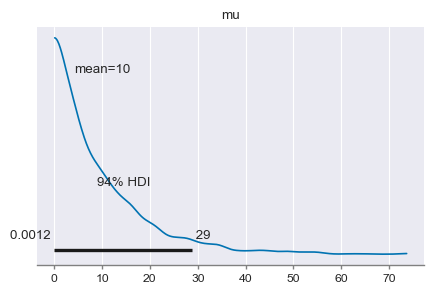

In [6]:
az.plot_posterior(idata.prior.mu)

Adesso inseriamo nel modello la verosimiglianza. La verosimiglianza di Poisson è simile a quella Binomiale, con la differenza che, nella Binomiale il numero di "successi" non può essere maggiore di $n$ (il numero di prove) mentre, nella distribuzione di Poisson non c'è un limite superiore. Consideriamo uno specifico paziente -- chiamiamolo Francesco.  Usando i 12 item della sottoscala relativa agli episodi di violenza fisica della *Conflict Tactics Scales-2* troviamo, per Mario, un numero di episodi violenti nei confronti del partner uguale a 4 (negli ultimi 6 mesi). Inseriamo dunque questa informazione nel modello bayesiano.

In [7]:
with pm.Model() as model:
    mu = pm.Exponential("mu", l)
    episodes = pm.Poisson("episodes", mu, observed=8)
    idata2 = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [8]:
sample_posterior = idata2.posterior['mu']

<AxesSubplot: title={'center': 'mu'}>

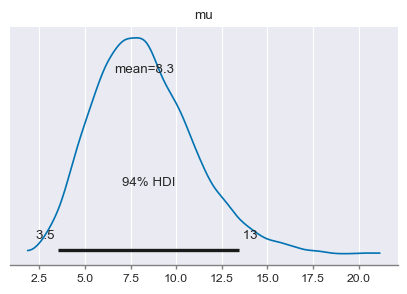

In [9]:
az.plot_posterior(sample_posterior)

In [10]:
with pm.Model() as model3:
    mu_A = pm.Exponential("mu_A", l)
    mu_B = pm.Exponential("mu_B", l)
    episodes_A = pm.Poisson("episodes_A", mu_A, observed=[8])
    episodes_B = pm.Poisson("episodes_B", mu_B, observed=[12])
    idata3 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


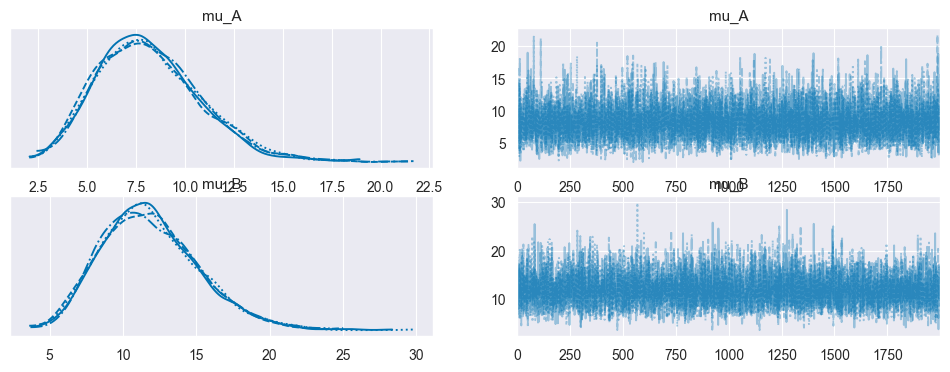

In [11]:
with model3:
    az.plot_trace(idata3)

In [12]:
mu_A = idata3.posterior['mu_A']
mu_B = idata3.posterior['mu_B']
mu_B.mean(), mu_A.mean()

(<xarray.DataArray 'mu_B' ()>
 array(11.86626402),
 <xarray.DataArray 'mu_A' ()>
 array(8.19263351))

<AxesSubplot: title={'center': 'mu_B'}>

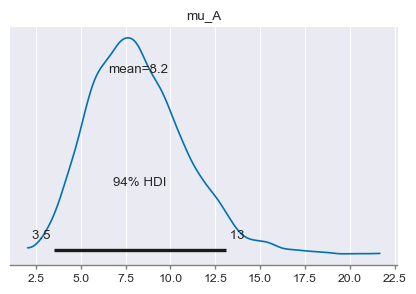

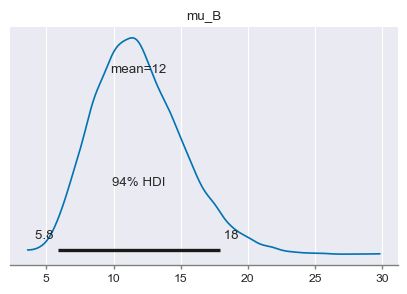

In [13]:
az.plot_posterior(mu_A)
az.plot_posterior(mu_B)

In [15]:
(mu_B > mu_A).mean()

<xarray.DataArray ()>
array(0.815)

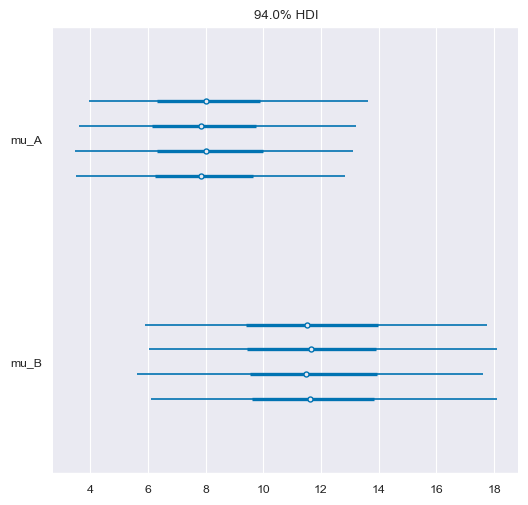

In [16]:
_ = az.plot_forest(idata3, var_names=["mu_A", "mu_B"])

In [17]:
with pm.Model() as model4:
    mu_A = pm.Exponential("mu_A", l)
    episodes_A = pm.Poisson("episodes_A", mu_A, observed=[8])
    idata4 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [18]:
with model3:
    post_pred = pm.sample_posterior_predictive(idata3)

In [19]:
post_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

<AxesSubplot: title={'center': 'episodes_A\n0'}>

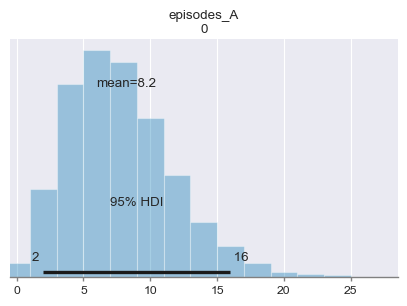

In [20]:
az.plot_posterior(post_pred.posterior_predictive.episodes_A, hdi_prob=0.95)

<AxesSubplot: title={'center': 'episodes_B\n0'}>

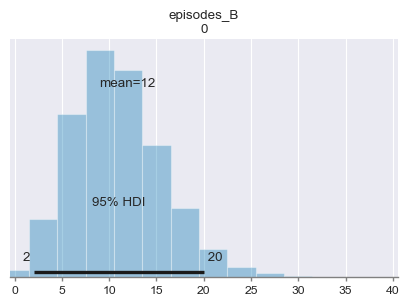

In [21]:
az.plot_posterior(post_pred.posterior_predictive.episodes_B, hdi_prob=0.95)


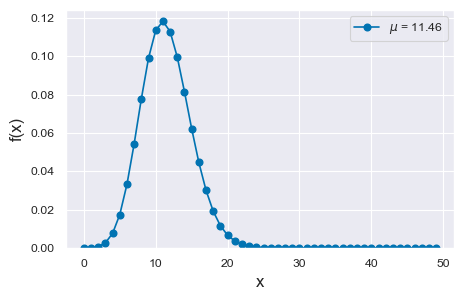

In [22]:
x = np.arange(0, 50)
m = 11.46
pmf = st.poisson.pmf(x, m)
plt.plot(x, pmf, '-o', label='$\mu$ = {}'.format(m))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.ylim(0)
plt.legend(loc=1)
plt.show()


## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w